## Importeer bibliotheken

In [41]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Laad de geveltekening in
De afbeelding wordt geladen met alpha-kanaal als dat beschikbaar is. De afmetingen worden weergegeven

In [42]:
## half_vrijstaand_type_e

# img = cv2.imread(r"Data_nest_uitgesneden\half_vrijstaand_type_e (1).png")
# img = cv2.imread(r"Data_nest_uitgesneden\half_vrijstaand_type_e (4).png")
### Test en validatie
img = cv2.imread(r"Data_nest_uitgesneden\rijwoning (6).png")
# img = cv2.imread(r"Data_nest_uitgesneden\rug_rug (1).png")
# img = cv2.imread(r"Data_nest_uitgesneden\half_vrijstaand_type_e (4).png")
# img = cv2.imread(r"Data_nest_uitgesneden\rijwoning (10).png")

## Toon de originele geveltekening

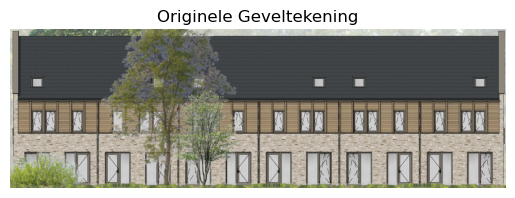

In [43]:
# Converteer de afbeelding naar RGB voor correcte weergave met matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Toon de originele geveltekening
plt.imshow(img_rgb)
plt.title("Originele Geveltekening")
plt.axis('off')
plt.show()

## Zet afbeelding om naar grijswaarden

Voor veel beeldverwerkingstaken zoals randdetectie is kleurinformatie niet nodig. 
Door de afbeelding om te zetten naar grijswaarden:

- Verminderen we de hoeveelheid gegevens (van 3 kanalen naar 1).
- Worden randen en vormen duidelijker.
- Gaat de verwerking sneller en efficiënter.

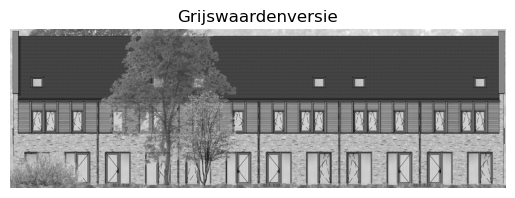

In [44]:
# Converteer afbeelding naar grijswaarden
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Toon grijswaardenafbeelding
plt.imshow(img_gray, cmap='gray')
plt.title("Grijswaardenversie")
plt.axis('off')
plt.show()

## Randdetectie met Canny

We passen de Canny-algoritme toe op de grijswaardenversie van de afbeelding om de randen te detecteren.  
Dit helpt bij het isoleren van structuren zoals muren, ramen en deuren.  

De gekozen drempelwaarden `(50, 150)` bepalen de gevoeligheid van de detectie:

- Waarden onder `50` worden als geen rand beschouwd.
- Waarden boven `150` worden altijd als rand geaccepteerd.
- Waarden daartussen worden alleen als rand gezien als ze verbonden zijn met sterke randen.

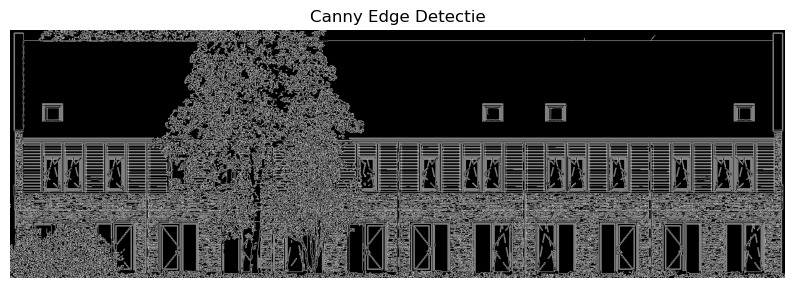

In [45]:
# Pas Canny edge detectie toe
edges = cv2.Canny(img_gray, threshold1=50, threshold2=150)

# Toon het resultaat van de edge-detectie
plt.figure(figsize=(10, 6))
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detectie")
plt.axis('off')
plt.show()

## Het resultaat

De drempelwaarden van **50 en 150** blijken in de praktijk het beste resultaat te geven.  
We hebben deze waarden getest op meerdere foto's, en ze leveren consistente detectie op voor zowel ramen als deuren.

Wanneer we andere drempelwaarden gebruiken, zien we dat het resultaat soms goed is voor één afbeelding, maar leidt tot fouten bij andere.  
Bijvoorbeeld: bij een te lage drempel worden randen van ramen niet goed gedetecteerd, terwijl bij een te hoge drempel kleinere details zoals deuren verloren gaan.

Daarom kiezen we deze waarden als standaard, omdat ze het meest betrouwbaar zijn over verschillende gevelafbeeldingen.


## Contourdetectie met `cv2.findContours`

### Canny Edge Detectie

In deze cel wordt de Canny edge detectie toegepast op de grijswaardenversie van de afbeelding.  
De functie `cv2.findContours` wordt vervolgens gebruikt om de randen (contouren) van objecten te vinden in een binaire afbeelding, bijvoorbeeld als resultaat van Canny-edge detectie.  
Een **contour** is een reeks coördinaten die gezamenlijk de omtrek van een object vormen.

---

### Reden voor het gebruik van `RETR_TREE`

Het contour-ophaalmodel `cv2.RETR_TREE` haalt niet alleen alle contouren op, maar bewaart ook de **hiërarchische relatie** tussen objecten.  
Deze hiërarchie is essentieel bij technische tekeningen, zoals geveltekeningen, waarin structuren elkaar kunnen bevatten:

- Hoofdstructuur (zoals een gebouw) wordt als **parent** herkend  
- Interne elementen (zoals ramen en deuren) als **children**  
- Substructuren (zoals glas in een raam) als **kind van een kind**

Op deze manier ontstaat een gestructureerd inzicht dat noodzakelijk is voor een correcte interpretatie van complexe bouwkundige tekeningen.

---

### Vergelijking met andere modi

| Mode            | Aanbevolen | Toelichting                                                                 |
|-----------------|------------|------------------------------------------------------------------------------|
| `RETR_EXTERNAL` | Nee     | Detecteert alleen buitencontour; interne structuren zoals ramen ontbreken   |
| `RETR_LIST`     | Nee     | Levert een lijst van contouren zonder hiërarchie; relatie tussen objecten ontbreekt |
| `RETR_CCOMP`    | Nee     | Slechts twee hiërarchische niveaus; onvoldoende voor gedetailleerde tekeningen |
| `RETR_TREE`     | Ja      | Volledige hiërarchie; geschikt voor het herkennen van complexe objectstructuren |

---

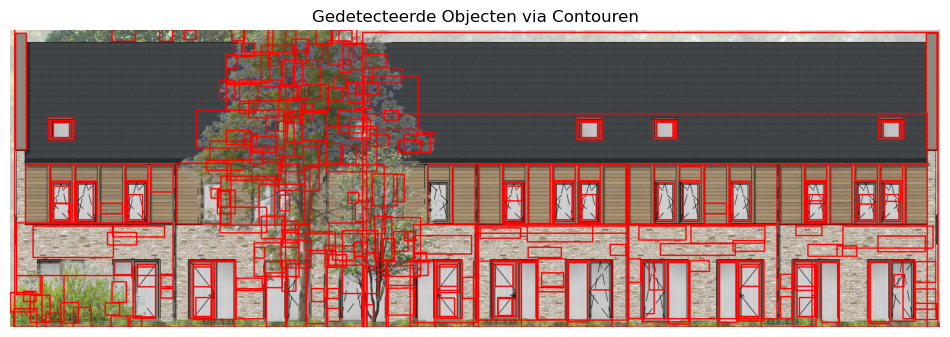

In [46]:
# Zoek contouren in het edge-detectiebeeld
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Maak een kopie van de originele afbeelding om contouren op te tekenen
img_contours = img_rgb.copy()

# Teken bounding boxes rond voldoende grote contouren
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    # Filter te kleine contouren weg (ruis)
    if w > 20 and h > 20:
        cv2.rectangle(img_contours, (x, y), (x + w, y + h), (255, 0, 0), 2)



# Plot resultaat
plt.figure(figsize=(12, 8))
plt.imshow(img_contours)
plt.title("Gedetecteerde Objecten via Contouren")
plt.axis('off')
plt.show()

## Conclusie: Contourdetectie op gevelafbeelding

De contourdetectie met `cv2.findContours` (in combinatie met `RETR_TREE`) resulteert in een gedetailleerde identificatie van objectranden binnen de geveltekening. Er is gekozen om alleen contouren met een minimale breedte en hoogte van 20 pixels weer te geven, om ruis te verminderen.

### Observaties

- **Hoofdlijnen van ramen en deuren worden correct herkend**, inclusief de onderliggende structuur.
- **Meerdere contouren op één object**:
  - Sommige ramen en deuren bevatten meerdere rechthoeken, veroorzaakt door lijndetails zoals raamkozijnen of glasverdelingen.
- **Contouren in achtergrondobjecten** (zoals de boom links) worden eveneens meegenomen.
- **Verbindingen tussen muur en dak** zorgen voor grotere contouren die meerdere elementen tegelijk omhullen.
- **Geen semantisch onderscheid**: het algoritme herkent vormen, maar weet niet of het om een raam, deur of boomtak gaat.

### Algemene beoordeling

De `RETR_TREE`-structuur is effectief voor het reconstrueren van hiërarchieën in bouwkundige tekeningen. Echter, voor nauwkeurige objectclassificatie is aanvullende filtering of contextuele interpretatie nodig.
